In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 294 kB 5.4 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 139 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 64.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 129.8 MB/s eta 0:00:01


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=random_seed)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [5]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [6]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit_LBFGS(self, f, env_dict, alpha):
        """Fit the coefficients of a function f using L-BFGS optimization.

        Parameters
        ----------
        f : torch.nn.Module
            The function to optimize.
        env_dict : dict
            A dictionary containing input features 'x' and labels 'y' for different environments.
        alpha : int

        Returns
        ------
        coef : float
            Optimized coefficient.
        """
        def closure():
            optimizer.zero_grad()
            risks = torch.stack([loss_fn(env_dict[e]['y'].to(self.device), f(env_dict[e]['x'].to(self.device))) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            return cvar
        
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()
        
        # Set f to training mode and move it to the same device as the data
        f.train()
        f.to(self.device)
        
        optimizer = optim.LBFGS(f.parameters())
        
        max_iter = 2
        for epoch in range(max_iter):
            optimizer.step(closure)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{max_iter}], Loss: {closure().item()}")
        
        # Set f back to evaluation mode
        f.eval()
        
        return f
    
    def fit(self, f, env_dict, alpha):        
        """Fit the coefficients of a function f. 

        Parameters
        ----------
        env_dict : dict
        alpha : int

        Returns
        ------
        coef : float
        """
        learning_rate = 0.01
        num_epochs= 200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].cuda(),f(env_dict[e]['x'].cuda())) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 


**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [7]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

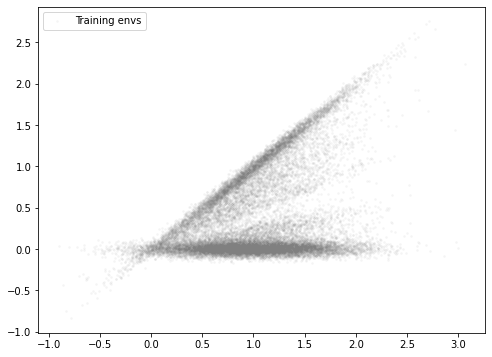

In [8]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 25
size_train, size_test = 100 , 100
theta_dist="beta" 
rho="cvar"
dim = 1
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [100/200], Loss: 0.2489808201789856
Epoch [200/200], Loss: 0.2482185661792755
0.05 0.588013768196106
Epoch [100/200], Loss: 0.24620164930820465
Epoch [200/200], Loss: 0.24619972705841064
0.1 0.3759745657444
Epoch [100/200], Loss: 0.2573615610599518
Epoch [200/200], Loss: 0.25736159086227417
0.15 0.38100114464759827
Epoch [100/200], Loss: 0.2664291262626648
Epoch [200/200], Loss: 0.26642900705337524
0.2 0.3818233907222748
Epoch [100/200], Loss: 0.2754736840724945
Epoch [200/200], Loss: 0.2754732072353363
0.25 0.38932687044143677
Epoch [100/200], Loss: 0.283571720123291
Epoch [200/200], Loss: 0.283571720123291
0.3 0.3996429443359375
Epoch [100/200], Loss: 0.29200664162635803
Epoch [200/200], Loss: 0.29200664162635803
0.35 0.410868376493454
Epoch [100/200], Loss: 0.29931071400642395
Epoch [200/200], Loss: 0.2992989718914032
0.4 0.4240450859069824
Epoch [100/200], Loss: 0.3063177764415741
Epoch [200/200], Loss: 0.3063177466392517
0.45 0.44072863459587097
Epoch [100/200], Loss: 0.3123

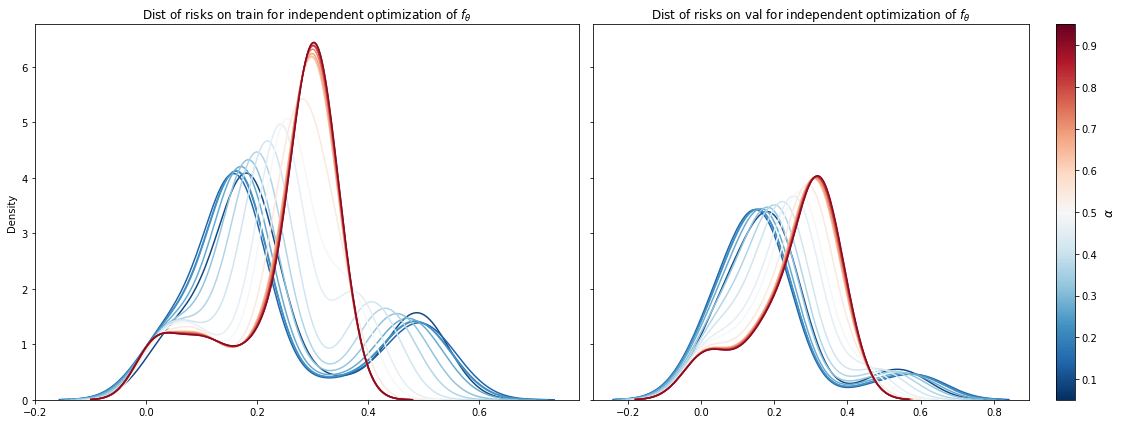

In [9]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
f = FHatNetwork(dim,[],1).cuda()
for i in tqdm(rg):
    ARM_Regression(name=rho).fit(f, data_dict_train, i/100)  
    print(i/100, f.model.weight.data.item())
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), f(data_dict_train[e]['x'].cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[0],color=diverging_colors[len(rg)-j], label=str(i/100))
        #test 
        risks = torch.stack([loss_fn(data_dict_test[e]['y'].cuda(), f(data_dict_test[e]['x'].cuda())) for e in data_dict_test.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[1],color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = f.state_dict()
    results.at[i, "cvar"] = cvar_emp
    j+=1

ax[0].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax[1].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')

ax[0].set_title(r"Dist of risks on train for independent optimization of $f_\theta$")
ax[1].set_title(r"Dist of risks on val for independent optimization of $f_\theta$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
# Add colorbar
ax[1].figure.colorbar(sm).set_label(label=r'$\alpha$', labelpad=5, size=12)
plt.tight_layout()
plt.show()

In [12]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 25
size_train, size_test = 10000 , 1000
theta_dist="beta" 
rho="cvar"
dim = 10
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [100/200], Loss: 0.047267451882362366
Epoch [200/200], Loss: 0.04726405441761017
Epoch [100/200], Loss: 0.04812036454677582
Epoch [200/200], Loss: 0.048119623214006424
Epoch [100/200], Loss: 0.04896458983421326
Epoch [200/200], Loss: 0.04896435886621475
Epoch [100/200], Loss: 0.049701325595378876
Epoch [200/200], Loss: 0.04970116168260574
Epoch [100/200], Loss: 0.05045666545629501
Epoch [200/200], Loss: 0.05045580863952637
Epoch [100/200], Loss: 0.0511324405670166
Epoch [200/200], Loss: 0.05113087594509125
Epoch [100/200], Loss: 0.05187763273715973
Epoch [200/200], Loss: 0.05187571048736572
Epoch [100/200], Loss: 0.05255161598324776
Epoch [200/200], Loss: 0.05255042389035225
Epoch [100/200], Loss: 0.053240932524204254
Epoch [200/200], Loss: 0.05324074253439903
Epoch [100/200], Loss: 0.05387214943766594
Epoch [200/200], Loss: 0.05387158691883087
Epoch [100/200], Loss: 0.05451934039592743
Epoch [200/200], Loss: 0.054515499621629715
Epoch [100/200], Loss: 0.05526832118630409
Epoch [

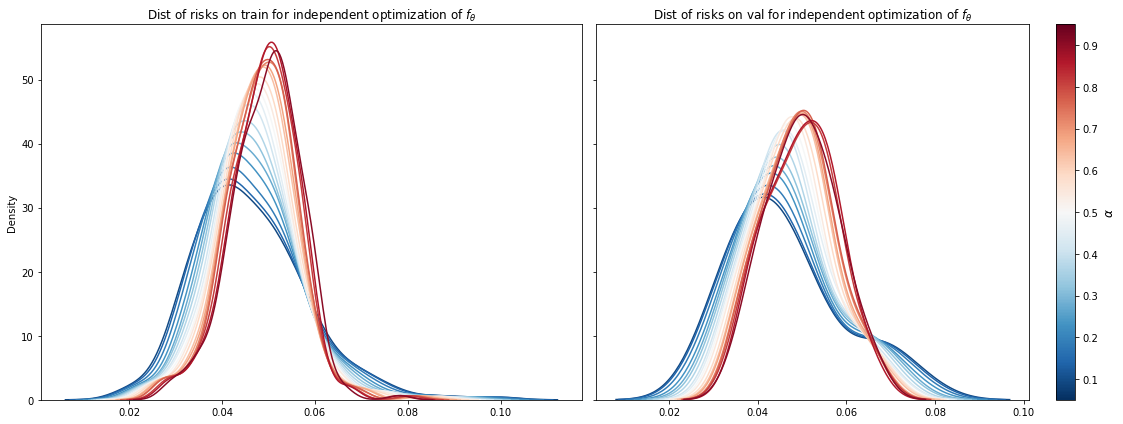

In [13]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
rg = range(5,100,5)
diverging_colors = sns.color_palette("RdBu", len(rg))
j=1
f = FHatNetwork(dim,[],1).cuda()
for i in tqdm(rg):
    ARM_Regression(name=rho).fit(f, data_dict_train, i/100)  
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), f(data_dict_train[e]['x'].cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[0],color=diverging_colors[len(rg)-j], label=str(i/100))
        #test 
        risks = torch.stack([loss_fn(data_dict_test[e]['y'].cuda(), f(data_dict_test[e]['x'].cuda())) for e in data_dict_test.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks, i/100)     
        sns.kdeplot(risks.cpu().numpy(), ax=ax[1],color=diverging_colors[len(rg)-j], label=str(i/100))
    
    results.at[i, "alpha"] = i/100
    results.at[i, "theta_hat"] = f.state_dict()
    results.at[i, "cvar"] = cvar_emp
    j+=1

ax[0].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax[1].legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')

ax[0].set_title(r"Dist of risks on train for independent optimization of $f_\theta$")
ax[1].set_title(r"Dist of risks on val for independent optimization of $f_\theta$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax[0].get_legend().remove()
ax[1].get_legend().remove()
# Add colorbar
ax[1].figure.colorbar(sm).set_label(label=r'$\alpha$', labelpad=5, size=12)
plt.tight_layout()
plt.show()